In [40]:
# """
# Four Cross-Sectional Ranked Strategies
# ======================================
# 
# Strategies:
# 1. Momentum (medium-term)
# 2. Short-Term Mean Reversion
# 3. Low Volatility (defensive)
# 4. ML Alpha (simple tree-based ranking)
# 
# All strategies:
# - Use daily data
# - Generate daily cross-sectional signals
# - Each day: long top decile, short bottom decile (dollar-neutral)
# - Equal-weight within long and short sides
# - No transaction costs included (add later if desired)
# """
# 
# from __future__ import annotations
# 
# import numpy as np
# import pandas as pd
# import yfinance as yf
# import matplotlib.pyplot as plt
# 
# from dataclasses import dataclass
# from typing import Dict, Tuple, List
# 
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# 
# # ---------------------------------------------------------------------
# # CONFIG
# # ---------------------------------------------------------------------
# 
# 
# MARKET_INDEX = "^GSPC"
# 
# START_DATE = "2015-01-01"
# END_DATE = "2025-11-30"
# 
# TRADING_DAYS_PER_YEAR = 252
# 
# # Signal windows (in trading days)
# MOM_WINDOW = 60      # ~3 months
# REV_WINDOW = 120      
# VOL_WINDOW = 120      # 
# BETA_WINDOW = 60     # for ML beta feature
# 
# TOP_DECILE = 0.10    # long top x% of ranks
# BOTTOM_DECILE = 0.05 # short bottom x% of ranks
# 
# 
# # ---------------------------------------------------------------------
# # UTILITIES
# # ---------------------------------------------------------------------
# 
# def download_price_data(
#     tickers: List[str],
#     start: str,
#     end: str
# ) -> pd.DataFrame:
#     """
#     Download adjusted close prices for given tickers using yfinance.
#     """
#     data = yf.download(tickers, start=start, end=end, auto_adjust=True)["Close"]
#     if isinstance(data, pd.Series):
#         data = data.to_frame()
#     return data.sort_index().dropna(how="all")
# 
# 
# def compute_returns(prices: pd.DataFrame) -> pd.DataFrame:
#     """
#     Simple daily returns.
#     """
#     rets = prices.pct_change()
#     return rets.dropna(how="all")
# 
# 
# def annualised_return(returns: pd.Series, freq: int = TRADING_DAYS_PER_YEAR) -> float:
#     r = returns.dropna()
#     if len(r) == 0:
#         return np.nan
#     total = (1.0 + r).prod()
#     years = len(r) / freq
#     if years <= 0:
#         return np.nan
#     return total ** (1.0 / years) - 1.0
# 
# 
# def annualised_vol(returns: pd.Series, freq: int = TRADING_DAYS_PER_YEAR) -> float:
#     r = returns.dropna()
#     if len(r) == 0:
#         return np.nan
#     return r.std(ddof=1) * np.sqrt(freq)
# 
# 
# def sharpe_ratio(returns: pd.Series, rf: float = 0.0, freq: int = TRADING_DAYS_PER_YEAR) -> float:
#     ann_ret = annualised_return(returns, freq)
#     ann_vol = annualised_vol(returns, freq)
#     if not np.isfinite(ann_vol) or ann_vol == 0:
#         return np.nan
#     return (ann_ret - rf) / ann_vol
# 
# 
# # ---------------------------------------------------------------------
# # SIGNALS
# # ---------------------------------------------------------------------
# 
# def momentum_signal(returns: pd.DataFrame, window: int) -> pd.DataFrame:
#     """
#     Cross-sectional momentum: past cumulative return over 'window' days.
#     """
#     # (1 + r).prod - 1 over rolling window
#     roll_prod = (1.0 + returns).rolling(window).apply(np.prod, raw=True) - 1.0
#     return roll_prod
# 
# 
# def mean_reversion_signal(returns: pd.DataFrame, window: int) -> pd.DataFrame:
#     """
#     Short-term mean reversion: negative of recent cumulative return.
#     If a stock strongly underperformed recently, we give it a positive score (expect bounce).
#     """
#     recent_cumret = (1.0 + returns).rolling(window).apply(np.prod, raw=True) - 1.0
#     return -recent_cumret   # invert -> underperformers get positive signal
# 
# 
# def volatility_signal(returns: pd.DataFrame, window: int) -> pd.DataFrame:
#     """
#     Low-volatility signal: we want LOWER vol to be better.
#     So we compute rolling vol and invert sign: signal = -vol.
#     """
#     vol = returns.rolling(window).std()
#     return -vol  # negative vol -> low vol = high signal
# 
# 
# def compute_beta_to_market(
#     returns: pd.DataFrame,
#     market_ret: pd.Series,
#     window: int
# ) -> pd.DataFrame:
#     """
#     Rolling CAPM beta of each stock to market index.
#     Beta_i,t = Cov(r_i, r_m) / Var(r_m)
#     """
#     aligned_mkt = market_ret.reindex(returns.index)
#     betas = pd.DataFrame(index=returns.index, columns=returns.columns, dtype=float)
# 
#     for col in returns.columns:
#         cov = returns[col].rolling(window).cov(aligned_mkt)
#         var = aligned_mkt.rolling(window).var()
#         betas[col] = cov / var
# 
#     return betas
# 
# 
# def ml_alpha_signal(
#     returns: pd.DataFrame,
#     market_ret: pd.Series,
#     mom_window: int,
#     rev_window: int,
#     vol_window: int,
#     beta_window: int,
#     train_start_buffer: int = 252 * 2,  # require 2 years of history before first training
#     random_state: int = 42,
# ) -> pd.DataFrame:
#     """
#     Fully leak-free ML alpha:
#     - Expanding window (uses all data up to t)
#     - Retrains once per month
#     - Predicts only out-of-sample for the next month
#     - Uses lagged features only
# 
#     Returns:
#         score_matrix (DataFrame: date x ticker)
#     """
# 
#     idx = returns.index
#     tickers = returns.columns
# 
#     # --------------------------
#     # 1. Precompute features
#     # --------------------------
#     mom = (1 + returns).rolling(mom_window).apply(np.prod, raw=True) - 1
#     rev = (1 + returns).rolling(rev_window).apply(np.prod, raw=True) - 1
#     vol = returns.rolling(vol_window).std()
# 
#     beta = compute_beta_to_market(returns, market_ret, beta_window)
# 
#     # All features must be one day *before* prediction
#     # ML at day t can only use features up to day t
#     features = pd.concat(
#         {"mom": mom, "rev": rev, "vol": vol, "beta": beta},
#         axis=1
#     )
# 
#     # --------------------------
#     # 2. Initialize empty score matrix
#     # --------------------------
#     scores = pd.DataFrame(index=idx, columns=tickers, dtype=float)
# 
#     # --------------------------
#     # 3. Monthly walk-forward loop
#     # --------------------------
#     months = sorted({(d.year, d.month) for d in idx})
# 
#     for i in range(2, len(months) - 1):
# 
#         # Current training end = end of previous month
#         train_year, train_month = months[i - 1]
#         train_end_date = idx[(idx.year == train_year) & (idx.month == train_month)].max()
# 
#         # Prediction month
#         pred_year, pred_month = months[i]
#         pred_mask = (idx.year == pred_year) & (idx.month == pred_month)
#         pred_dates = idx[pred_mask]
# 
#         # Must ensure enough history
#         available_history = idx[idx <= train_end_date]
#         if len(available_history) < train_start_buffer:
#             continue
# 
#         # --------------------------
#         # Build training panel
#         # --------------------------
#         train_mask = (idx <= train_end_date)
#         feat_train = features.loc[train_mask]
#         ret_train = returns.shift(-1).loc[train_mask]     # predict next-day return
# 
#         panel = []
#         for d in available_history:
#             if d >= train_end_date:
#                 continue
#             if d not in ret_train.index or d not in feat_train.index:
#                 continue
#             # skip if any feature missing for that day
#             if feat_train.loc[d].isna().any():
#                 continue
#             # record for each ticker
#             for tkr in tickers:
#                 y = ret_train.at[d, tkr]
#                 if np.isnan(y):
#                     continue
#                 x = [
#                     feat_train.at[d, ('mom', tkr)],
#                     feat_train.at[d, ('rev', tkr)],
#                     feat_train.at[d, ('vol', tkr)],
#                     feat_train.at[d, ('beta', tkr)],
#                 ]
#                 if any(np.isnan(x)):
#                     continue
#                 panel.append((d, tkr, x, y))
# 
#         if len(panel) < 500:
#             # too little clean training data
#             continue
# 
#         dfp = pd.DataFrame(panel, columns=["date", "ticker", "x", "y"])
#         X_train = np.vstack(dfp["x"])
#         y_train = dfp["y"].values
# 
#         # --------------------------
#         # Train the ML model
#         # --------------------------
#         model = Pipeline([
#             ("scaler", StandardScaler()),
#             ("gbm", GradientBoostingRegressor(
#                 n_estimators=200,
#                 max_depth=3,
#                 learning_rate=0.05,
#                 random_state=random_state
#             ))
#         ])
# 
#         model.fit(X_train, y_train)
# 
#         # --------------------------
#         # Predict next-month scores
#         # --------------------------
#         feat_pred = features.loc[pred_dates]
# 
#         for d in pred_dates:
#             row = []
#             for tkr in tickers:
#                 x = [
#                     feat_pred.at[d, ('mom', tkr)],
#                     feat_pred.at[d, ('rev', tkr)],
#                     feat_pred.at[d, ('vol', tkr)],
#                     feat_pred.at[d, ('beta', tkr)],
#                 ]
#                 if any(np.isnan(x)):
#                     row.append(np.nan)
#                 else:
#                     row.append(model.predict([x])[0])
#             scores.loc[d] = row
# 
#     return scores
# 
# # ---------------------------------------------------------------------
# # CROSS-SECTIONAL RANKED PORTFOLIO
# # ---------------------------------------------------------------------
# 
# def build_long_short_weights_from_scores(
#     scores: pd.Series,
#     long_frac: float = TOP_DECILE,
#     short_frac: float = BOTTOM_DECILE
# ) -> pd.Series:
#     """
#     Given scores for a single date (cross-section),
#     - rank stocks
#     - long top 'long_frac' percentile (equal-weight)
#     - short bottom 'short_frac' percentile (equal-weight)
#     - dollar-neutral: sum(w) = 0
#     """
#     scores = scores.dropna()
#     if len(scores) == 0:
#         return pd.Series(0.0, index=scores.index)
# 
#     N = len(scores)
#     ranks = scores.rank(method="first")  # 1 = lowest
# 
#     long_cut = 1.0 - long_frac
#     short_cut = short_frac
# 
#     quantiles = ranks / (N + 1.0)
# 
#     long_names = quantiles[quantiles >= long_cut].index
#     short_names = quantiles[quantiles <= short_cut].index
# 
#     w = pd.Series(0.0, index=scores.index)
# 
#     if len(long_names) > 0:
#         w.loc[long_names] = 1.0 / len(long_names)
#     if len(short_names) > 0:
#         w.loc[short_names] = -1.0 / len(short_names)
# 
#     # Already dollar-neutral: sum(w) ~ 0, if counts match.
#     return w
# 
# 
# def backtest_ranked_strategy(
#     scores: pd.DataFrame,
#     returns: pd.DataFrame,
#     name: str
# ) -> Tuple[pd.Series, pd.Series]:
#     """
#     Backtest a cross-sectional ranked strategy:
#     - Each day: build weights from scores of that day
#     - Apply weights to next day's returns
#     - Return daily pnl series and equity curve
#     """
#     common_idx = scores.index.intersection(returns.index)
#     scores = scores.loc[common_idx]
#     returns = returns.loc[common_idx]
# 
#     # We need weights at t, returns at t+1
#     dates = common_idx
#     pnl_list = []
#     pnl_index = []
# 
#     for i in range(len(dates) - 1):
#         date_t = dates[i]
#         date_next = dates[i + 1]
# 
#         scores_t = scores.loc[date_t]
#         w_t = build_long_short_weights_from_scores(scores_t)
# 
#         r_next = returns.loc[date_next]
#         pnl = float((w_t.reindex(r_next.index).fillna(0.0) * r_next).sum())
# 
#         pnl_list.append(pnl)
#         pnl_index.append(date_next)
# 
#     pnl_series = pd.Series(pnl_list, index=pnl_index, name=f"{name}_returns")
#     equity = (1.0 + pnl_series).cumprod()
#     equity.name = f"{name}_equity"
# 
#     return pnl_series, equity
# 
# 
# # ---------------------------------------------------------------------
# # MAIN SCRIPT
# # ---------------------------------------------------------------------
# 
# def main() -> None:
#     # 1. Download prices
#     prices_all = download_price_data(UNIVERSE + [MARKET_INDEX], START_DATE, END_DATE)
#     prices = prices_all[UNIVERSE].dropna(how="all")
#     mkt_prices = prices_all[MARKET_INDEX].dropna()
# 
#     # Align
#     common_idx = prices.index.intersection(mkt_prices.index)
#     prices = prices.loc[common_idx]
#     mkt_prices = mkt_prices.loc[common_idx]
# 
#     # 2. Returns
#     returns = compute_returns(prices)
#     mkt_returns = compute_returns(mkt_prices.to_frame()).iloc[:, 0]
#     common_idx = returns.index.intersection(mkt_returns.index)
#     returns = returns.loc[common_idx]
#     mkt_returns = mkt_returns.loc[common_idx]
# 
#     print("Data shape:", returns.shape)
# 
#     # 3. Build signals
#     mom_sig = momentum_signal(returns, MOM_WINDOW)
#     rev_sig = mean_reversion_signal(returns, REV_WINDOW)
#     vol_sig = volatility_signal(returns, VOL_WINDOW)
#     # ml_sig = ml_alpha_signal(
#     #     returns,
#     #     mkt_returns,
#     #     mom_window=MOM_WINDOW,
#     #     rev_window=REV_WINDOW,
#     #     vol_window=VOL_WINDOW,
#     #     beta_window=BETA_WINDOW,
#     # )
# 
#     # 4. Backtest each strategy
#     strategies = {
#         "Momentum": mom_sig,
#         "Reversion": rev_sig,
#         "LowVol": vol_sig,
#         # "ML": ml_sig,
#     }
# 
#     results: Dict[str, Tuple[pd.Series, pd.Series]] = {}
# 
#     for name, sig in strategies.items():
#         # Drop early NaNs due to rolling windows
#         valid_sig = sig.dropna(how="all")
#         # Intersect with returns
#         ci = valid_sig.index.intersection(returns.index)
#         valid_sig = valid_sig.loc[ci]
#         rets_ci = returns.loc[ci]
# 
#         pnl, eq = backtest_ranked_strategy(valid_sig, rets_ci, name)
#         results[name] = (pnl, eq)
# 
#         print(f"\n=== {name} Strategy ===")
#         print(f"Annualised return: {annualised_return(pnl)*100:.2f}%")
#         print(f"Annualised vol   : {annualised_vol(pnl)*100:.2f}%")
#         print(f"Sharpe (rf=0)    : {sharpe_ratio(pnl, rf=0.0):.2f}")
# 
#     # 5. Plot equity curves
#     plt.figure(figsize=(12, 6))
#     for name, (pnl, eq) in results.items():
#         plt.plot(eq, label=name)
#     plt.title("Equity Curves: Ranked Long/Short Strategies")
#     plt.xlabel("Date")
#     plt.ylabel("Equity (normalised)")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

In [41]:
# if __name__ == "__main__":
#     main()

In [58]:
from __future__ import annotations

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import List, Optional, Dict



# ---------------------------------------------------------------------
# CONFIG
# ---------------------------------------------------------------------

START_DATE = "2015-01-01"
END_DATE   = "2025-11-30"
TRADING_DAYS_PER_YEAR = 252

N_BUCKETS = 10

# ---------------------------------------------------------------------
# DATA LOADING
# ---------------------------------------------------------------------

def download_ohlc(
    tickers: List[str],
    start: str,
    end: str,
    auto_adjust: bool = True,
) -> Dict[str, pd.DataFrame]:
    """
    Download OHLC using yfinance. Returns dict with keys: 'Open', 'Close'.
    Output DataFrames are indexed by date, columns are tickers.
    """
    data = yf.download(
        tickers,
        start=start,
        end=end,
        auto_adjust=auto_adjust,
        progress=False,
        group_by="column",
    )

    # yfinance returns:
    # - MultiIndex columns if multiple tickers: data['Open'] is a DF (cols=tickers)
    # - Single Index columns if 1 ticker: data['Open'] is a Series
    def _extract(field: str) -> pd.DataFrame:
        x = data[field]
        if isinstance(x, pd.Series):
            # single ticker
            return x.to_frame(name=tickers[0])
        return x

    open_ = _extract("Open").sort_index().dropna(how="all")
    close_ = _extract("Close").sort_index().dropna(how="all")

    # Align indexes (important)
    idx = open_.index.intersection(close_.index)
    open_ = open_.loc[idx]
    close_ = close_.loc[idx]

    return {"Open": open_, "Close": close_}


# ---------------------------------------------------------------------
# RETURNS & SIGNALS
# ---------------------------------------------------------------------

def close_to_close_returns(close: pd.DataFrame) -> pd.DataFrame:
    """Close-to-close daily returns, no padding of NaNs."""
    return close.pct_change(fill_method=None).dropna(how="all")


def open_to_close_returns(open_: pd.DataFrame, close: pd.DataFrame) -> pd.DataFrame:
    """Intraday returns: Close/Open - 1."""
    r = close / open_ - 1.0
    return r.dropna(how="all")


def forward_close_to_close_return(close: pd.DataFrame, horizon: int) -> pd.DataFrame:
    """
    Forward H-day return aligned at time t:
        fwd_ret[t] = close[t+H] / close[t] - 1
    """
    return close.shift(-horizon) / close - 1.0


def forward_open_to_close_return(open_u: pd.DataFrame, close_u: pd.DataFrame, horizon: int) -> pd.DataFrame:
    """
    Forward trade return aligned at date t, assuming:
      - signal known at close(t)
      - enter at open(t+1)
      - exit at close(t+horizon)

    fwd_ret[t] = close[t+horizon] / open[t+1] - 1
    """
    fwd = close_u.shift(-horizon) / open_u.shift(-1) - 1.0
    # last 'horizon' rows are invalid because close[t+horizon] doesn't exist
    return fwd.iloc[:-horizon]


def momentum_signal_from_close_returns(
    close_cc_returns: pd.DataFrame,
    window: int = 21,
) -> pd.DataFrame:
    """
    Momentum signal computed from close-to-close returns:
        prod(1+r) - 1 over a rolling window.
    Uses only past data up to t.
    """
    return (1.0 + close_cc_returns).rolling(window).apply(np.prod, raw=True) - 1.0


# ---------------------------------------------------------------------
# METRICS
# ---------------------------------------------------------------------

def annualised_return(r: pd.Series, freq: int = TRADING_DAYS_PER_YEAR) -> float:
    r = r.dropna()
    if len(r) == 0:
        return np.nan
    total = (1.0 + r).prod()
    years = len(r) / freq
    return total ** (1.0 / years) - 1.0 if years > 0 else np.nan


def annualised_vol(r: pd.Series, freq: int = TRADING_DAYS_PER_YEAR) -> float:
    r = r.dropna()
    return r.std(ddof=1) * np.sqrt(freq) if len(r) > 0 else np.nan


def sharpe_ratio(r: pd.Series, rf: float = 0.0, freq: int = TRADING_DAYS_PER_YEAR) -> float:
    vol = annualised_vol(r, freq)
    if not np.isfinite(vol) or vol == 0:
        return np.nan
    return (annualised_return(r, freq) - rf) / vol


# ---------------------------------------------------------------------
# BUCKET ASSIGNMENT (INSPECTABLE)
# ---------------------------------------------------------------------

def assign_buckets_qcut(
    sig: pd.Series,
    n_buckets: int,
) -> pd.Series:
    """
    Assign bucket labels 1..n_buckets using qcut on ranks.
    Uses ranks to reduce sensitivity to outliers.
    """
    sig = sig.dropna()
    if len(sig) == 0:
        return pd.Series(dtype=int)

    # Use ranks to handle non-normal signals; qcut wants continuous-ish values.
    ranks = sig.rank(method="first")

    # qcut can drop bins if there are too many ties; we prefer stable output,
    # but for liquid equities this is usually fine.
    bucket = pd.qcut(ranks, q=n_buckets, labels=False, duplicates="drop") + 1
    bucket = bucket.astype(int)
    return bucket


def bucket_composition(
    buckets: pd.Series,
) -> Dict[int, List[str]]:
    """
    Return dict: bucket_id -> list of tickers in that bucket.
    """
    out: Dict[int, List[str]] = {}
    for b in sorted(buckets.unique()):
        out[int(b)] = list(buckets[buckets == b].index)
    return out

def get_bucket_members(res: BucketBacktestResult, date: str, bucket_id: int) -> List[str]:
    d = pd.Timestamp(date)
    row = res.membership.loc[d]
    return row.index[row == bucket_id].tolist()


def summarize_day(res: BucketBacktestResult, date: str) -> pd.Series:
    d = pd.Timestamp(date)
    return res.counts.loc[d]


# ---------------------------------------------------------------------
# BACKTEST
# ---------------------------------------------------------------------

@dataclass
class BucketBacktestResult:
    bucket_returns: pd.DataFrame
    bucket_equity: pd.DataFrame
    bucket_stats: pd.DataFrame
    membership: pd.DataFrame   # formation date t x tickers => bucket id
    counts: pd.DataFrame       # formation date t x bucket_k => number of names


def compute_bucket_portfolios(
    signal_t: pd.DataFrame,
    fwd_returns_t: pd.DataFrame,
    n_buckets: int = 10,
    min_stocks: Optional[int] = None,
) -> BucketBacktestResult:
    """
    IMPORTANT: `signal_t` and `fwd_returns_t` must both be aligned at formation date t.

    Example for close-signal and next-day open->close PnL:
      fwd_returns_t = oc_returns.shift(-1)
    so that:
      fwd_returns_t.loc[t] uses OC(t+1), which is tradable after observing signal at close(t).
    """
    idx = signal_t.index.intersection(fwd_returns_t.index)
    signal_t = signal_t.loc[idx]
    fwd_returns_t = fwd_returns_t.loc[idx]

    tickers = signal_t.columns.intersection(fwd_returns_t.columns)
    signal_t = signal_t[tickers]
    fwd_returns_t = fwd_returns_t[tickers]

    if min_stocks is None:
        min_stocks = max(n_buckets, int(0.5 * len(tickers)))

    dates = signal_t.index
    bucket_names = [f"bucket_{i+1}" for i in range(n_buckets)]

    bucket_ret_list, bucket_ret_index = [], []
    membership_rows, membership_index = [], []
    counts_rows, counts_index = [], []

    for t in dates:
        sig = signal_t.loc[t]
        fwd = fwd_returns_t.loc[t]   # already aligned at t

        mask = sig.notna() & fwd.notna()
        if mask.sum() < min_stocks:
            continue

        sig_valid = sig[mask]
        fwd_valid = fwd[mask]

        buckets = assign_buckets_qcut(sig_valid, n_buckets=n_buckets)

        # membership snapshot at formation t
        mem = pd.Series(index=tickers, dtype=float)
        mem.loc[:] = np.nan
        mem.loc[buckets.index] = buckets.values
        membership_rows.append(mem)
        membership_index.append(t)

        # counts per bucket
        cnt = pd.Series(0, index=bucket_names, dtype=int)
        for b in range(1, n_buckets + 1):
            cnt[f"bucket_{b}"] = int((buckets == b).sum())
        counts_rows.append(cnt)
        counts_index.append(t)

        # bucket returns (equal-weight)
        bucket_ret = pd.Series(index=bucket_names, dtype=float)
        for b in range(1, n_buckets + 1):
            members = buckets[buckets == b].index
            bucket_ret[f"bucket_{b}"] = fwd_valid.loc[members].mean() if len(members) else np.nan

        bucket_ret_list.append(bucket_ret)
        bucket_ret_index.append(t)

    bucket_returns = pd.DataFrame(bucket_ret_list, index=bucket_ret_index)

    # Handle empty case cleanly
    if bucket_returns.empty:
        empty_stats = pd.DataFrame(columns=["ann_return", "ann_vol", "sharpe"])
        empty_membership = pd.DataFrame(index=pd.DatetimeIndex([]), columns=tickers, dtype=float)
        empty_counts = pd.DataFrame(index=pd.DatetimeIndex([]), columns=bucket_names, dtype=int)
        return BucketBacktestResult(bucket_returns, bucket_returns.copy(), empty_stats, empty_membership, empty_counts)

    bucket_equity = (1.0 + bucket_returns).cumprod()

    stats_dict = {}
    for col in bucket_returns.columns:
        r = bucket_returns[col]
        stats_dict[col] = {
            "ann_return": annualised_return(r),
            "ann_vol": annualised_vol(r),
            "sharpe": sharpe_ratio(r),
        }
    bucket_stats = pd.DataFrame.from_dict(stats_dict, orient="index")
    bucket_stats.index.name = "bucket"
    bucket_stats = bucket_stats[["ann_return", "ann_vol", "sharpe"]]

    membership = pd.DataFrame(membership_rows, index=membership_index)
    counts = pd.DataFrame(counts_rows, index=counts_index)

    return BucketBacktestResult(bucket_returns, bucket_equity, bucket_stats, membership, counts)



# ---------------------------------------------------------------------
# PLOTTING
# ---------------------------------------------------------------------

def plot_bucket_bar_chart(stats: pd.DataFrame, title: str = "") -> None:
    ann_rets = stats["ann_return"] * 100.0
    buckets = [int(x.split("_")[1]) for x in stats.index]

    plt.figure(figsize=(10, 5))
    plt.bar(buckets, ann_rets.values)
    plt.xlabel("Bucket (1 = lowest signal, N = highest)")
    plt.ylabel("Annualised Return (%)")
    plt.title(title or "Annualised Return by Bucket")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(buckets)
    plt.tight_layout()
    plt.show()


def plot_bucket_equity_curves(
    bucket_equity: pd.DataFrame,
    title: str = "",
    benchmark_equity: Optional[pd.Series] = None,
) -> None:
    plt.figure(figsize=(12, 6))
    for col in bucket_equity.columns:
        plt.plot(bucket_equity.index, bucket_equity[col], label=col, alpha=0.6)

    if benchmark_equity is not None:
        plt.plot(benchmark_equity.index, benchmark_equity.values, label="Benchmark", linestyle="--")

    plt.xlabel("Date")
    plt.ylabel("Cumulative Wealth")
    plt.title(title or "Bucket Equity Curves")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.tight_layout()
    plt.show()


=== Bucket Stats (Signal at close(t), PnL = OC(t+1)) ===
           ann_return_pct   ann_vol    sharpe
bucket                                       
bucket_1         2.463640  0.199744  0.123340
bucket_2         6.423922  0.171924  0.373650
bucket_3         3.486766  0.164114  0.212459
bucket_4        10.645861  0.152346  0.698797
bucket_5         8.436627  0.146004  0.577833
bucket_6         8.598238  0.144514  0.594975
bucket_7         9.260894  0.143843  0.643820
bucket_8         0.456966  0.147532  0.030974
bucket_9         1.301430  0.149570  0.087011
bucket_10        8.665007  0.172749  0.501594


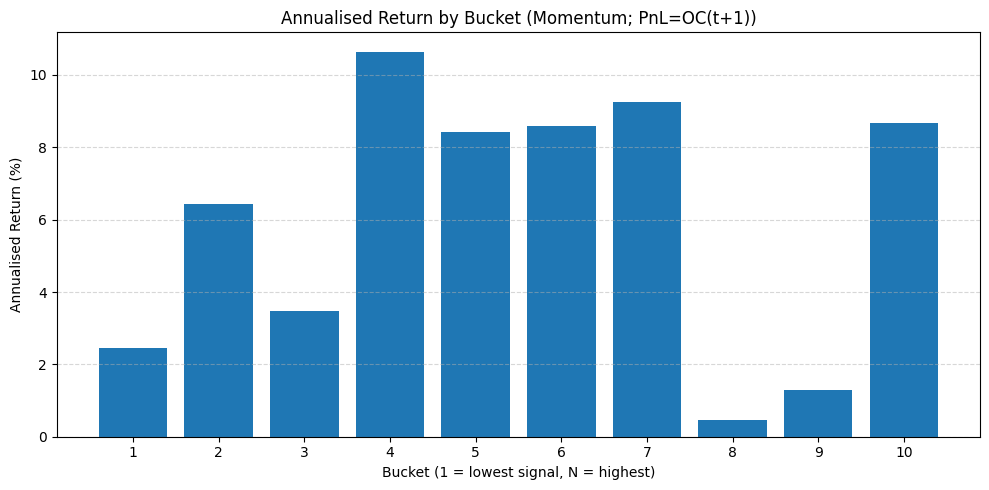

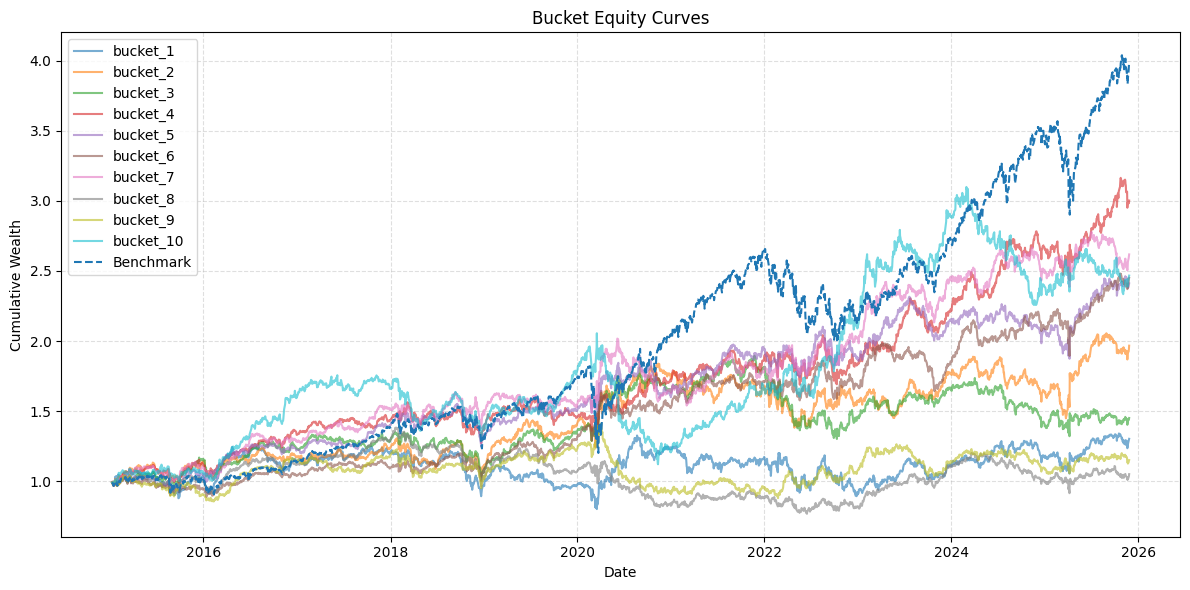


Example formation date t=2015-01-09:
Counts: {'bucket_1': 7, 'bucket_2': 6, 'bucket_3': 6, 'bucket_4': 6, 'bucket_5': 6, 'bucket_6': 6, 'bucket_7': 6, 'bucket_8': 6, 'bucket_9': 6, 'bucket_10': 7}
Bucket 10 members (first 15): ['AAPL', 'AVGO', 'UNH', 'PFE', 'MRK', 'PEP', 'WMT']


In [67]:
BENCHMARK_TICKER = "VOO"

UNIVERSE = [
    # Tech / Comm
    "AAPL", "MSFT", "GOOG", "GOOGL", "META", "AMZN", "NVDA",
    "AVGO", "ADBE", "CSCO", "ORCL", "CRM", "INTC", "TXN", "QCOM",
    "TSLA", "AMD",
    # Financials
    "JPM", "BAC", "WFC", "GS", "MS", "C", "BLK", "AXP", "SCHW",
    # Healthcare
    "UNH", "JNJ", "PFE", "MRK", "ABBV", "LLY", "TMO", "ABT", "BMY",
    # Consumer
    "PG", "KO", "PEP", "COST", "WMT", "MCD", "HD", "LOW",
    "NKE", "SBUX", "TGT",
    # Energy / Materials
    "XOM", "CVX", "COP", "SLB",
    # Industrials
    "CAT", "BA", "GE", "HON", "LMT", "UPS", "UNP",
    # Utilities / REITs
    "NEE", "DUK", "SO", "PLD", "AMT"
]


# ---------------------------------------------------------------------
# MAIN
# ---------------------------------------------------------------------

tickers = UNIVERSE + [BENCHMARK_TICKER]
ohlc = download_ohlc(tickers, START_DATE, END_DATE, auto_adjust=True)

open_ = ohlc["Open"]
close = ohlc["Close"]

open_u = open_[UNIVERSE]
close_u = close[UNIVERSE]

open_b = open_[[BENCHMARK_TICKER]]
close_b = close[[BENCHMARK_TICKER]]

# 1) Close-to-close returns for SIGNAL construction
cc_ret_u = close_to_close_returns(close_u)

# 2) Open-to-close returns (by day t)
oc_ret_u = open_to_close_returns(open_u, close_u)

# 3) Align PnL to formation date t: use next day's open->close
#    fwd_oc[t] = oc_ret[t+1]
fwd_oc_u = oc_ret_u.shift(-1)

# 4) Build momentum signal at close(t) from cc returns up to t
MOM_WINDOW = 5
signal = momentum_signal_from_close_returns(cc_ret_u, window=MOM_WINDOW)

# 5) Align and remove last day (no forward return after shifting)
idx = signal.index.intersection(fwd_oc_u.index)
signal = signal.loc[idx]
fwd_oc_u = fwd_oc_u.loc[idx]

# last row has NaNs due to shift(-1)
signal = signal.iloc[:-1]
fwd_oc_u = fwd_oc_u.iloc[:-1]

# 6) Backtest
res = compute_bucket_portfolios(
    signal_t=signal,
    fwd_returns_t=fwd_oc_u,
    n_buckets=N_BUCKETS,
    min_stocks=None,
)

# 7) Benchmark (buy-and-hold close->close, adjusted)
#    This is a standard "opportunity cost of capital" benchmark.
bench_cc = close_b.pct_change(fill_method=None).dropna(how="all").iloc[:, 0]
benchmark_equity = (1.0 + bench_cc.reindex(res.bucket_equity.index).dropna()).cumprod()

# 8) Report stats
stats = res.bucket_stats.copy()
stats["ann_return_pct"] = stats["ann_return"] * 100.0
print("\n=== Bucket Stats (Signal at close(t), PnL = OC(t+1)) ===")
print(stats[["ann_return_pct", "ann_vol", "sharpe"]])

# 9) Plot
plot_bucket_bar_chart(stats, title="Annualised Return by Bucket (Momentum; PnL=OC(t+1))")
plot_bucket_equity_curves(res.bucket_equity, title="Bucket Equity Curves", benchmark_equity=benchmark_equity)

# 10) Example inspection
if len(res.membership.index) > 0:
    example_date = res.membership.index[0]
    print(f"\nExample formation date t={example_date.date()}:")
    print("Counts:", res.counts.loc[example_date].to_dict())
    print("Bucket 10 members (first 15):", get_bucket_members(res, str(example_date.date()), 10)[:15])



=== Holding 1 days (enter open t+1, exit close t+1+1; non-overlapping) ===
           ann_return   ann_vol    sharpe
bucket_1     0.018209  0.137428  0.132499
bucket_2     0.033479  0.116932  0.286316
bucket_3     0.012716  0.112124  0.113408
bucket_4     0.065920  0.104257  0.632288
bucket_5     0.024438  0.098127  0.249047
bucket_6     0.043372  0.098216  0.441602
bucket_7     0.080580  0.100037  0.805500
bucket_8    -0.000097  0.099935 -0.000974
bucket_9    -0.002111  0.105380 -0.020030
bucket_10    0.008412  0.121705  0.069118


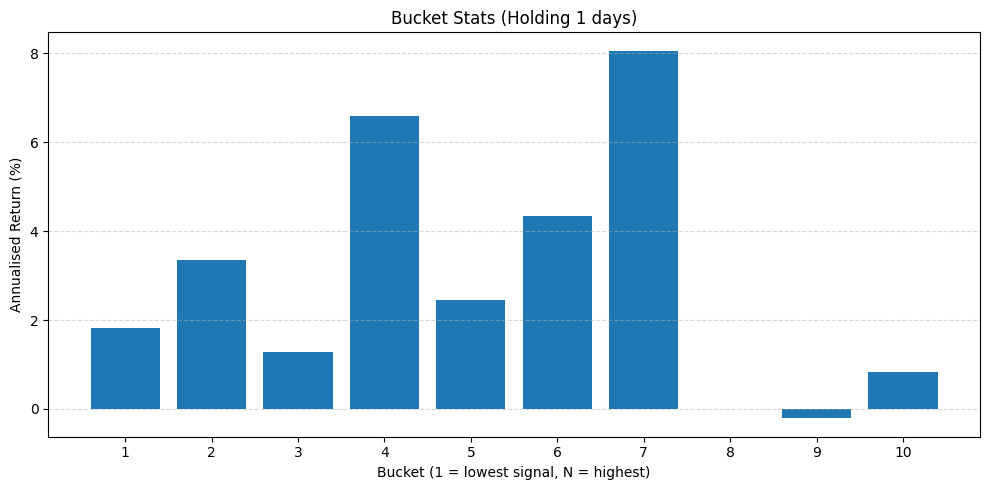

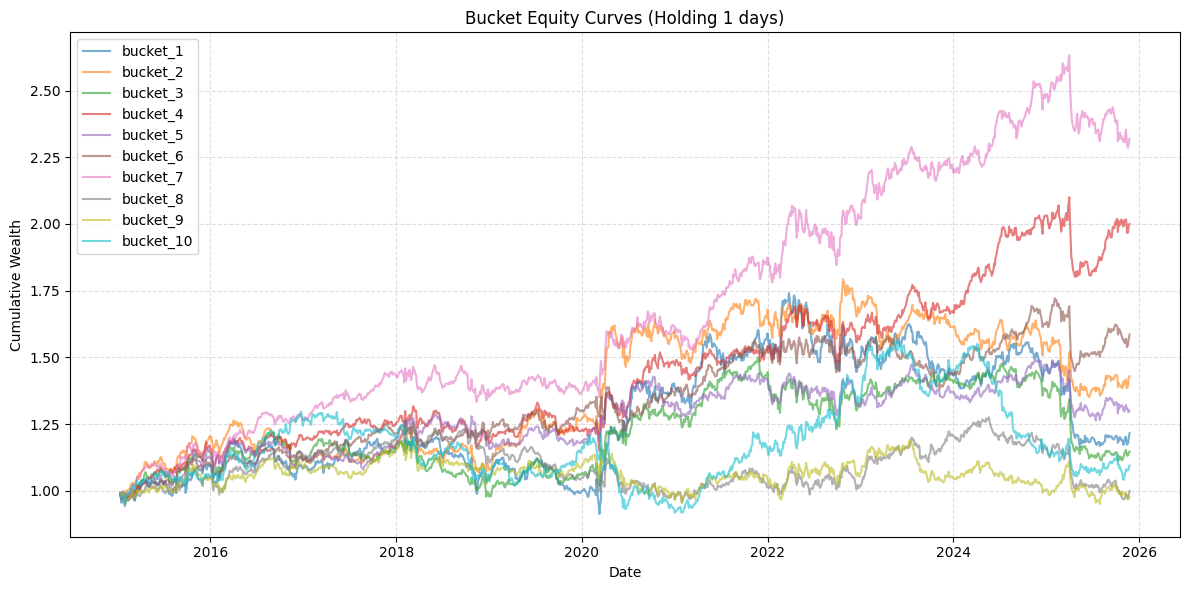


=== Holding 5 days (enter open t+1, exit close t+1+5; non-overlapping) ===
           ann_return   ann_vol    sharpe
bucket_1     0.122011  0.204936  0.595361
bucket_2     0.051580  0.171981  0.299919
bucket_3     0.091557  0.168711  0.542684
bucket_4     0.138314  0.161368  0.857135
bucket_5     0.120166  0.159242  0.754613
bucket_6     0.104082  0.148239  0.702122
bucket_7     0.166913  0.140065  1.191682
bucket_8     0.107235  0.150177  0.714059
bucket_9     0.096812  0.160055  0.604871
bucket_10    0.190156  0.178023  1.068154


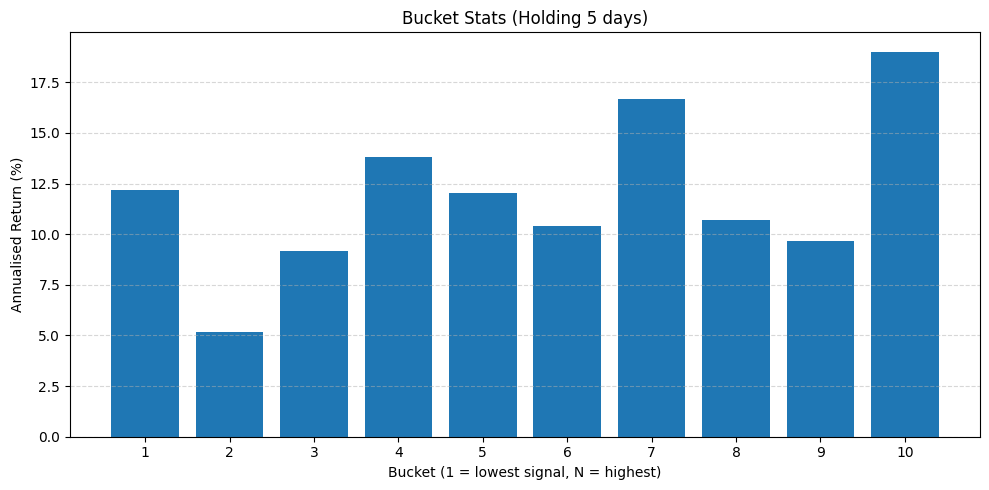

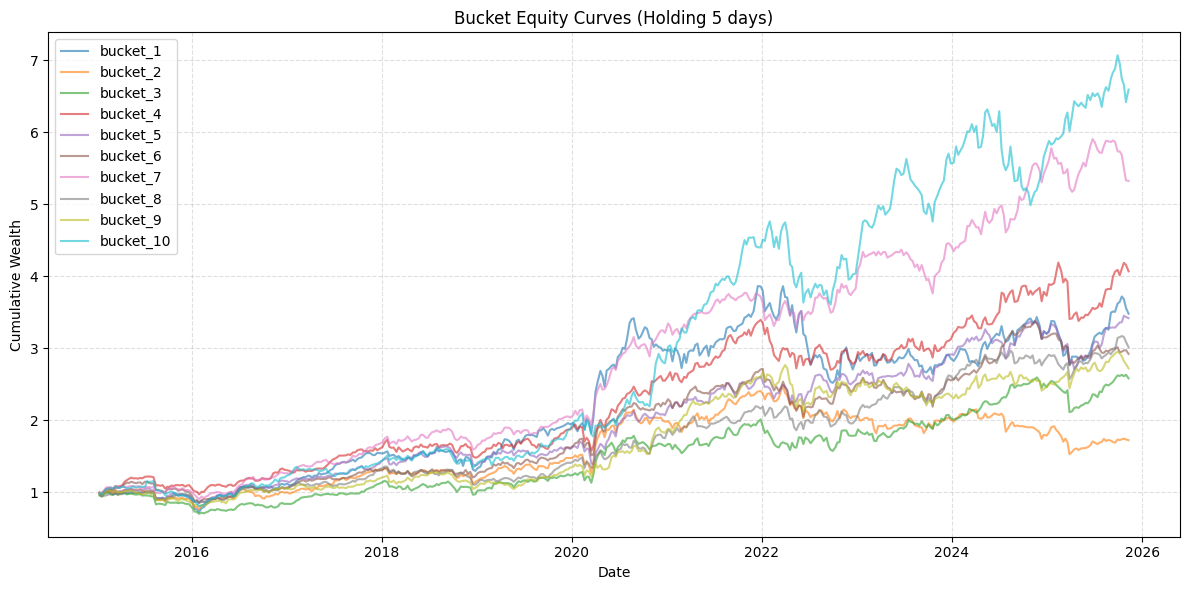


=== Holding 10 days (enter open t+1, exit close t+1+10; non-overlapping) ===
           ann_return   ann_vol    sharpe
bucket_1     0.142966  0.245737  0.581787
bucket_2     0.184915  0.201645  0.917036
bucket_3     0.173991  0.192319  0.904702
bucket_4     0.217108  0.187981  1.154950
bucket_5     0.112777  0.182813  0.616895
bucket_6     0.151913  0.170086  0.893154
bucket_7     0.143894  0.170943  0.841769
bucket_8     0.145541  0.181828  0.800432
bucket_9     0.127412  0.185233  0.687846
bucket_10    0.204609  0.196497  1.041283


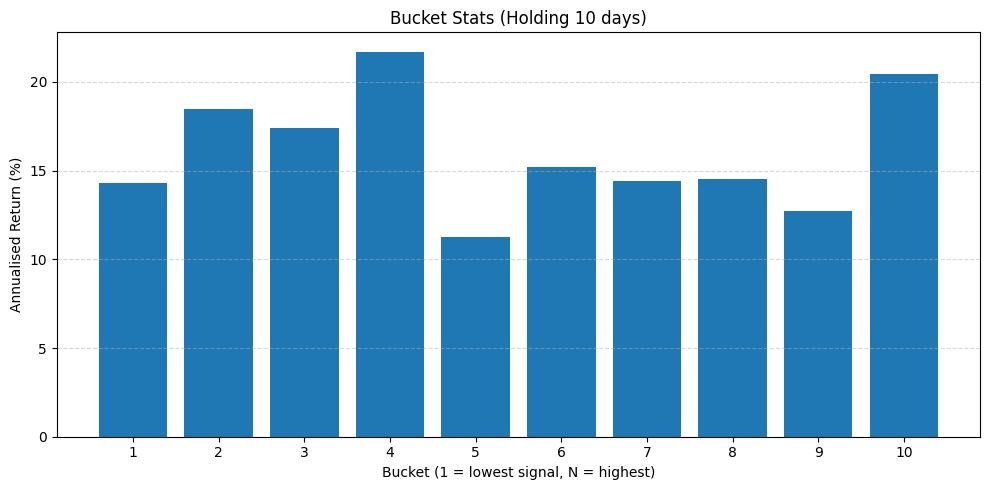

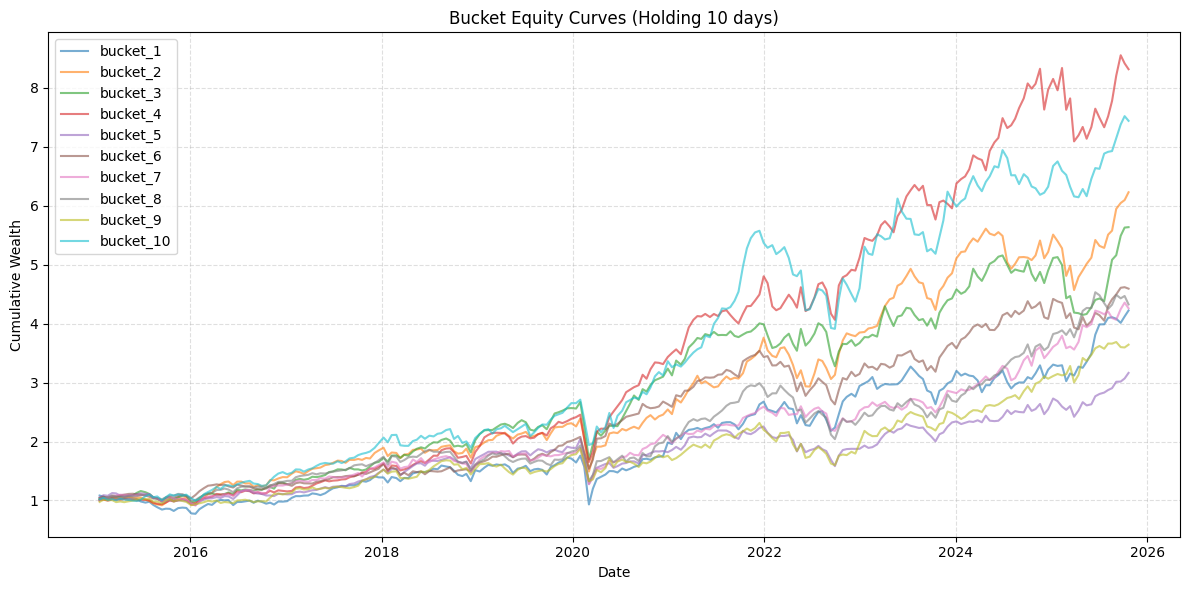


=== Holding 20 days (enter open t+1, exit close t+1+20; non-overlapping) ===
           ann_return   ann_vol    sharpe
bucket_1     0.196460  0.198182  0.991308
bucket_2     0.156874  0.171154  0.916571
bucket_3     0.152660  0.166364  0.917623
bucket_4     0.186343  0.162771  1.144820
bucket_5     0.140308  0.160249  0.875561
bucket_6     0.099275  0.153340  0.647417
bucket_7     0.150581  0.166822  0.902644
bucket_8     0.135377  0.163677  0.827097
bucket_9     0.153872  0.183715  0.837558
bucket_10    0.169890  0.224885  0.755452


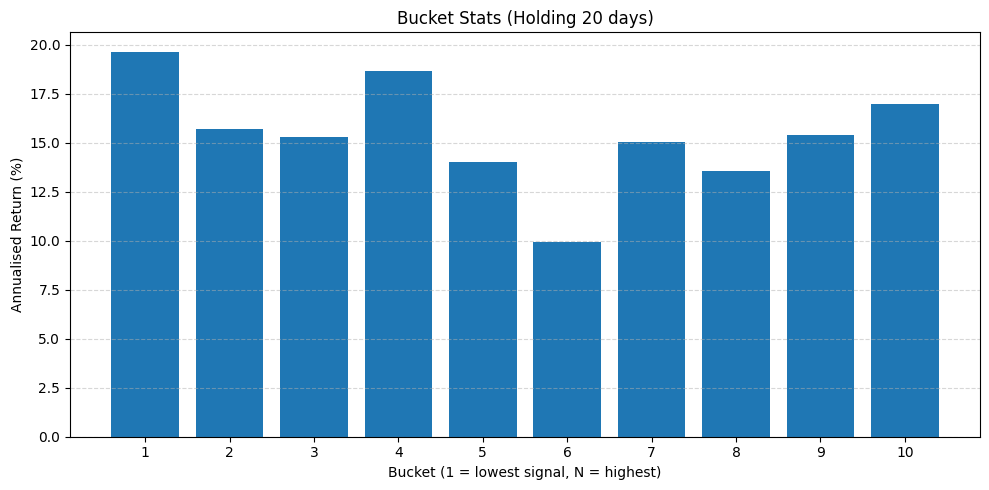

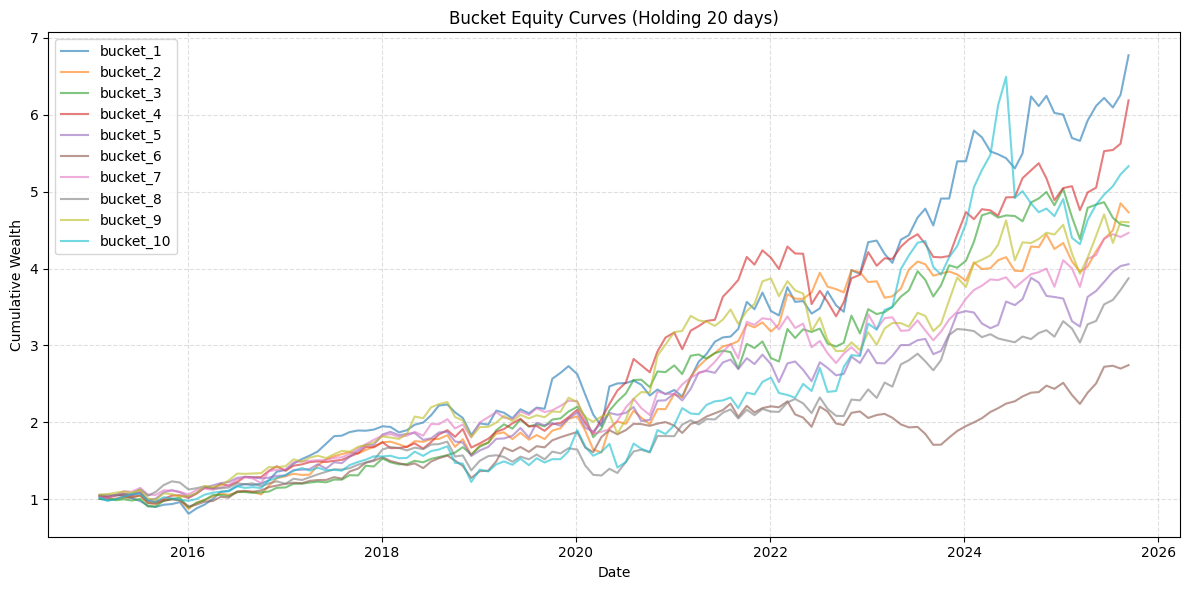

In [68]:
horizons = [1, 5, 10, 20]
results = {}

for H in horizons:
    # forward return aligned at formation date t
    fwd_ret = forward_open_to_close_return(open_u, close_u, horizon=H)
    fwd_ret = fwd_ret.iloc[:-(1 + H)]  # drop tail where exit is missing

    # non-overlapping formation dates (trade window length is H+1 calendar steps)
    step = H + 1
    dates = fwd_ret.index[::step]

    sig_H = signal.reindex(dates)
    fwd_H = fwd_ret.reindex(dates)

    resH = compute_bucket_portfolios(sig_H, fwd_H, n_buckets=10)
    results[H] = resH

    # correct annualisation frequency for H-day holds with step H+1
    freq = TRADING_DAYS_PER_YEAR / (H + 1)

    stats = {}
    for col in resH.bucket_returns.columns:
        r = resH.bucket_returns[col]
        stats[col] = {
            "ann_return": annualised_return(r, freq=freq),
            "ann_vol": annualised_vol(r, freq=freq),
            "sharpe": sharpe_ratio(r, freq=freq),
        }
    stats_df = pd.DataFrame(stats).T

    print(f"\n=== Holding {H} days (enter open t+1, exit close t+1+{H}; non-overlapping) ===")
    print(stats_df[["ann_return", "ann_vol", "sharpe"]])

    plot_bucket_bar_chart(stats_df, title=f"Bucket Stats (Holding {H} days)")
    plot_bucket_equity_curves(resH.bucket_equity, title=f"Bucket Equity Curves (Holding {H} days)")



=== Bucket Stats (Signal at close(t), PnL = OC(t+1)) ===
           ann_return_pct   ann_vol    sharpe
bucket                                       
bucket_1        -9.014550  0.260345 -0.346254
bucket_2       -11.460297  0.219085 -0.523099
bucket_3       -11.930593  0.197971 -0.602645
bucket_4        -5.094425  0.191501 -0.266026
bucket_5        -3.671393  0.181292 -0.202513
bucket_6        -6.440283  0.177370 -0.363099
bucket_7       -12.929383  0.185526 -0.696905
bucket_8       -13.669117  0.192589 -0.709758
bucket_9       -15.278487  0.209832 -0.728130
bucket_10      -29.941222  0.245112 -1.221533


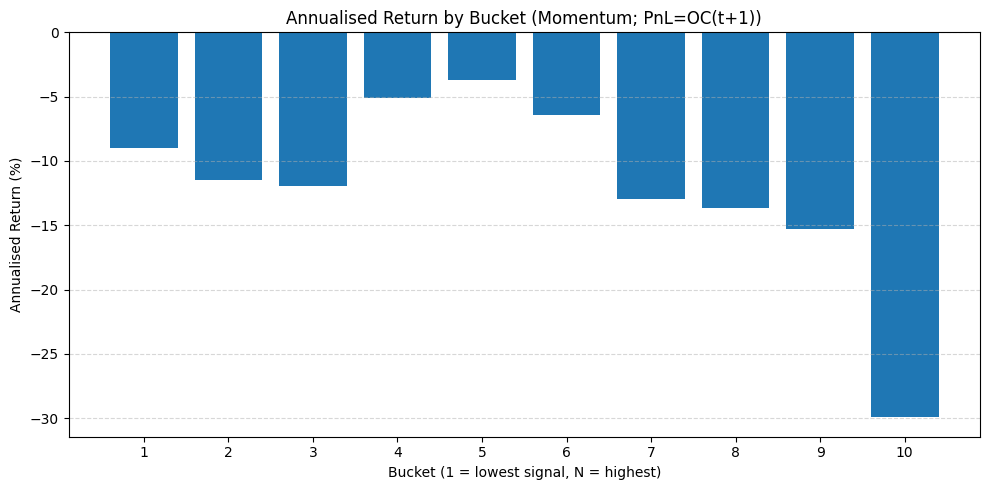

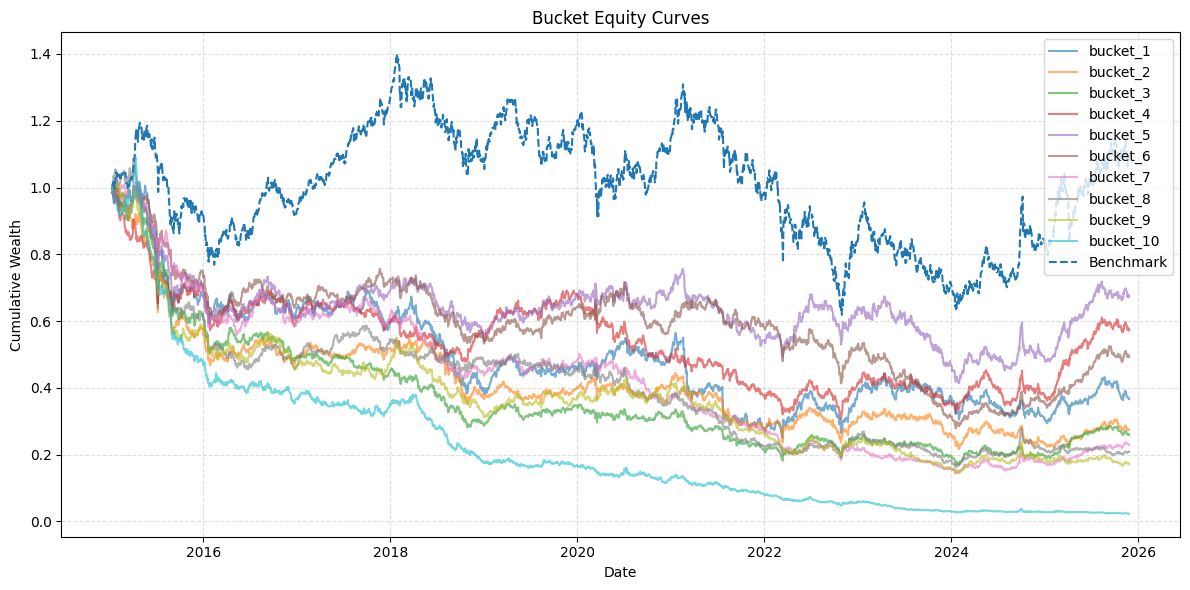


Example formation date t=2015-01-09:
Counts: {'bucket_1': 7, 'bucket_2': 6, 'bucket_3': 6, 'bucket_4': 6, 'bucket_5': 7, 'bucket_6': 6, 'bucket_7': 6, 'bucket_8': 6, 'bucket_9': 6, 'bucket_10': 7}
Bucket 10 members (first 15): ['2899.HK', '2688.HK', '1177.HK', '0700.HK', '0316.HK', '0285.HK', '0175.HK']


In [59]:
# ---------------------------------------------------------------------
# MAIN
# ---------------------------------------------------------------------

BENCHMARK_TICKER = '^HSI'

UNIVERSE = [
    "9999.HK", "9992.HK", "9988.HK", "9961.HK", "9901.HK", "9888.HK", "9633.HK", "9618.HK",
    "6862.HK", "6690.HK", "6618.HK", "3988.HK", "3968.HK", "3692.HK", "3690.HK", "2899.HK",
    "2688.HK", "2628.HK", "2618.HK", "2388.HK", "2382.HK", "2359.HK", "2331.HK", "2319.HK",
    "2318.HK", "2313.HK", "2269.HK", "2057.HK", "2020.HK", "2015.HK", "1997.HK", "1929.HK",
    "1928.HK", "1876.HK", "1810.HK", "1801.HK", "1398.HK", "1378.HK", "1299.HK", "1211.HK",
    "1209.HK", "1177.HK", "1113.HK", "1109.HK", "1099.HK", "1093.HK", "1088.HK", "1044.HK",
    "1038.HK", "1024.HK", "0992.HK", "0981.HK", "0968.HK", "0960.HK", "0941.HK", "0939.HK",
    "0883.HK", "0881.HK", "0868.HK", "0857.HK", "0836.HK", "0823.HK", "0762.HK", "0728.HK",
    "0700.HK", "0688.HK", "0669.HK", "0388.HK", "0386.HK", "0322.HK", "0316.HK", "0300.HK",
    "0291.HK", "0288.HK", "0285.HK", "0267.HK", "0241.HK", "0175.HK", "0101.HK", "0066.HK",
    "0027.HK", "0016.HK", "0012.HK", "0011.HK", "0006.HK", "0005.HK", "0003.HK", "0002.HK",
    "0001.HK"
]

tickers = UNIVERSE + [BENCHMARK_TICKER]
ohlc = download_ohlc(tickers, START_DATE, END_DATE, auto_adjust=True)

open_ = ohlc["Open"]
close = ohlc["Close"]

open_u = open_[UNIVERSE]
close_u = close[UNIVERSE]

open_b = open_[[BENCHMARK_TICKER]]
close_b = close[[BENCHMARK_TICKER]]

# 1) Close-to-close returns for SIGNAL construction
cc_ret_u = close_to_close_returns(close_u)

# 2) Open-to-close returns (by day t)
oc_ret_u = open_to_close_returns(open_u, close_u)

# 3) Align PnL to formation date t: use next day's open->close
#    fwd_oc[t] = oc_ret[t+1]
fwd_oc_u = oc_ret_u.shift(-1)

# 4) Build momentum signal at close(t) from cc returns up to t
MOM_WINDOW = 5
signal = momentum_signal_from_close_returns(cc_ret_u, window=MOM_WINDOW)

# 5) Align and remove last day (no forward return after shifting)
idx = signal.index.intersection(fwd_oc_u.index)
signal = signal.loc[idx]
fwd_oc_u = fwd_oc_u.loc[idx]

# last row has NaNs due to shift(-1)
signal = signal.iloc[:-1]
fwd_oc_u = fwd_oc_u.iloc[:-1]

# 6) Backtest
res = compute_bucket_portfolios(
    signal_t=signal,
    fwd_returns_t=fwd_oc_u,
    n_buckets=N_BUCKETS,
    min_stocks=None,
)

# 7) Benchmark (buy-and-hold close->close, adjusted)
#    This is a standard "opportunity cost of capital" benchmark.
bench_cc = close_b.pct_change(fill_method=None).dropna(how="all").iloc[:, 0]
benchmark_equity = (1.0 + bench_cc.reindex(res.bucket_equity.index).dropna()).cumprod()

# 8) Report stats
stats = res.bucket_stats.copy()
stats["ann_return_pct"] = stats["ann_return"] * 100.0
print("\n=== Bucket Stats (Signal at close(t), PnL = OC(t+1)) ===")
print(stats[["ann_return_pct", "ann_vol", "sharpe"]])

# 9) Plot
plot_bucket_bar_chart(stats, title="Annualised Return by Bucket (Momentum; PnL=OC(t+1))")
plot_bucket_equity_curves(res.bucket_equity, title="Bucket Equity Curves", benchmark_equity=benchmark_equity)

# 10) Example inspection
if len(res.membership.index) > 0:
    example_date = res.membership.index[0]
    print(f"\nExample formation date t={example_date.date()}:")
    print("Counts:", res.counts.loc[example_date].to_dict())
    print("Bucket 10 members (first 15):", get_bucket_members(res, str(example_date.date()), 10)[:15])



=== Holding 1 days (enter open t+1, exit close t+1+1; non-overlapping) ===
           ann_return   ann_vol    sharpe
bucket_1    -0.074986  0.184886 -0.405579
bucket_2    -0.114351  0.156991 -0.728388
bucket_3    -0.058791  0.139431 -0.421652
bucket_4    -0.055483  0.136795 -0.405593
bucket_5    -0.050435  0.129459 -0.389587
bucket_6    -0.038633  0.128247 -0.301240
bucket_7    -0.095536  0.130967 -0.729468
bucket_8    -0.102085  0.134968 -0.756368
bucket_9    -0.102122  0.151607 -0.673599
bucket_10   -0.183635  0.178340 -1.029690


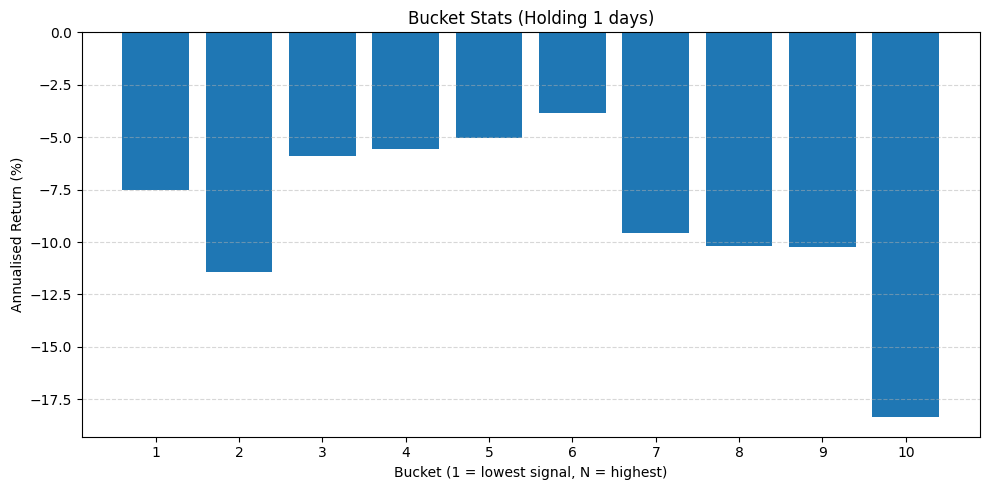

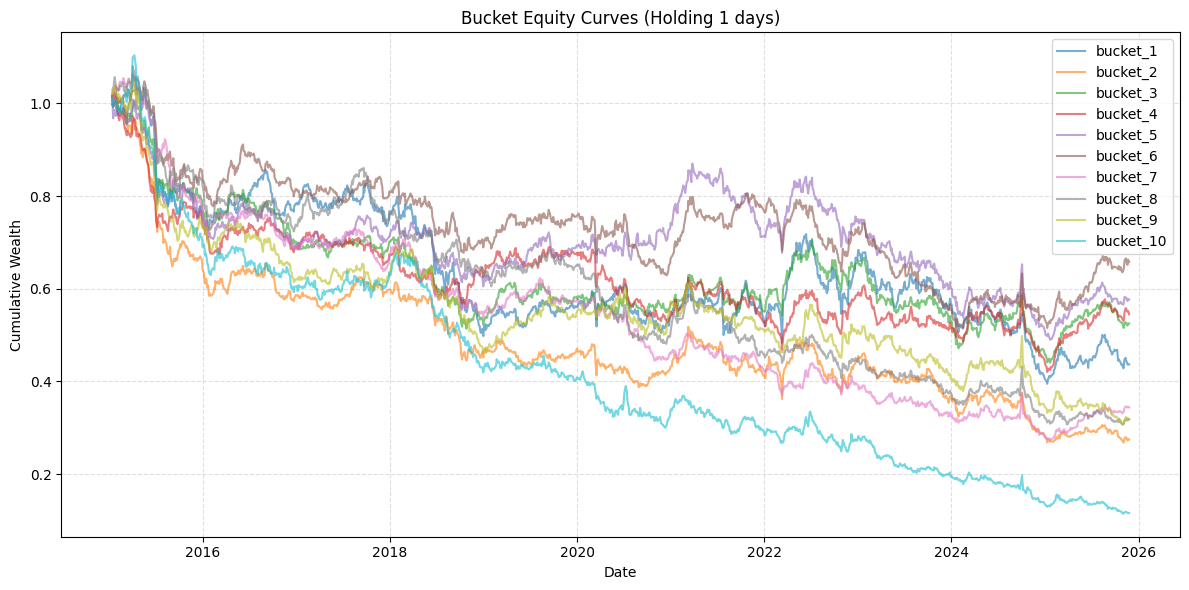


=== Holding 5 days (enter open t+1, exit close t+1+5; non-overlapping) ===
           ann_return   ann_vol    sharpe
bucket_1     0.048594  0.284849  0.170596
bucket_2     0.015467  0.254034  0.060885
bucket_3     0.073808  0.221196  0.333678
bucket_4     0.016429  0.221489  0.074175
bucket_5     0.029373  0.197387  0.148809
bucket_6     0.064848  0.207919  0.311890
bucket_7     0.007179  0.208055  0.034505
bucket_8    -0.011884  0.215650 -0.055108
bucket_9    -0.027462  0.235884 -0.116422
bucket_10   -0.050420  0.265106 -0.190186


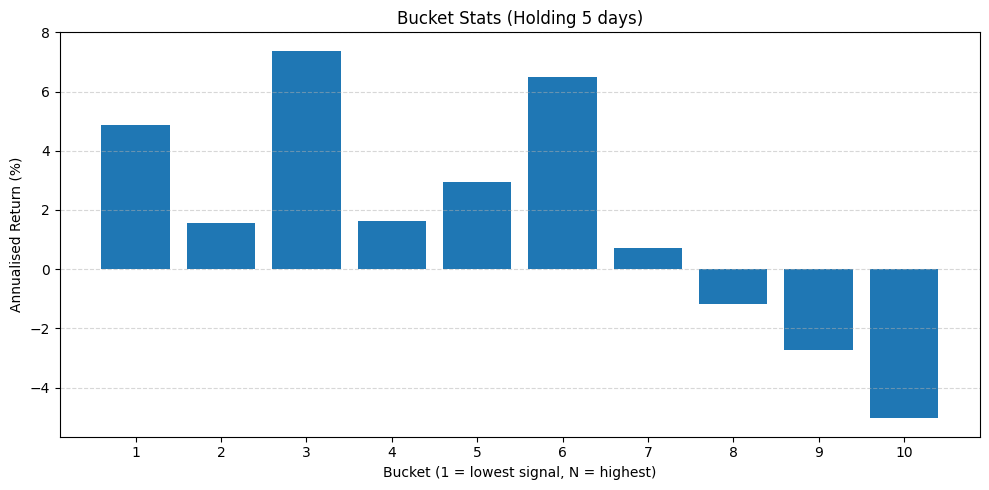

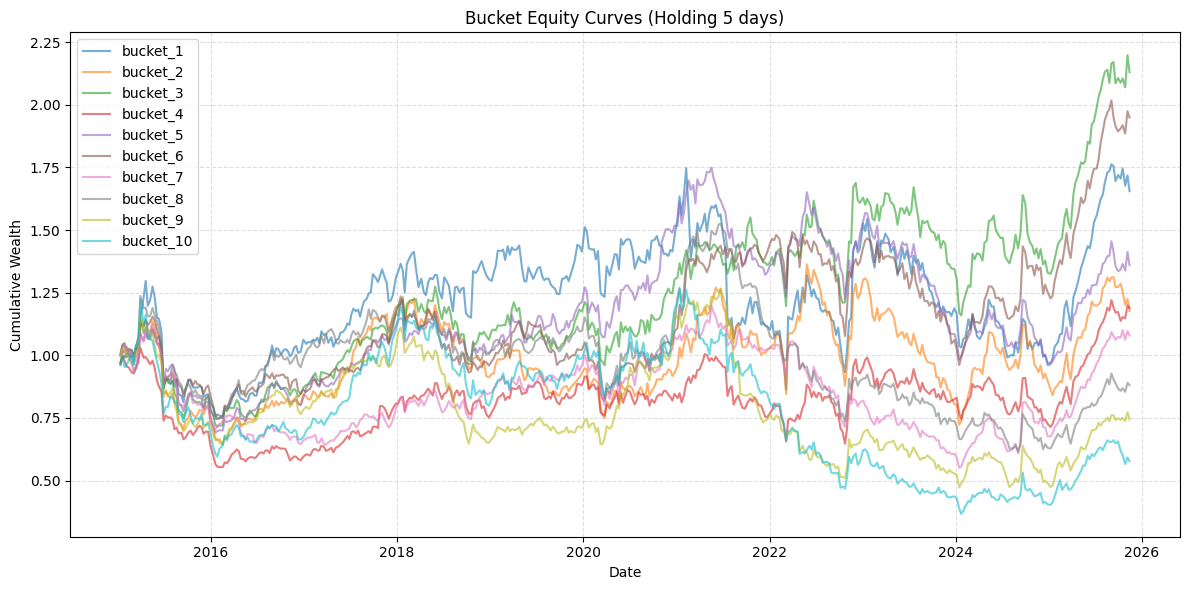


=== Holding 10 days (enter open t+1, exit close t+1+10; non-overlapping) ===
           ann_return   ann_vol    sharpe
bucket_1     0.106246  0.294476  0.360797
bucket_2     0.024363  0.233839  0.104188
bucket_3     0.004955  0.225782  0.021946
bucket_4     0.041253  0.223453  0.184616
bucket_5     0.096223  0.214742  0.448088
bucket_6     0.060860  0.209249  0.290849
bucket_7     0.030780  0.216465  0.142195
bucket_8     0.059999  0.220844  0.271680
bucket_9     0.065511  0.221231  0.296122
bucket_10    0.095424  0.264500  0.360773


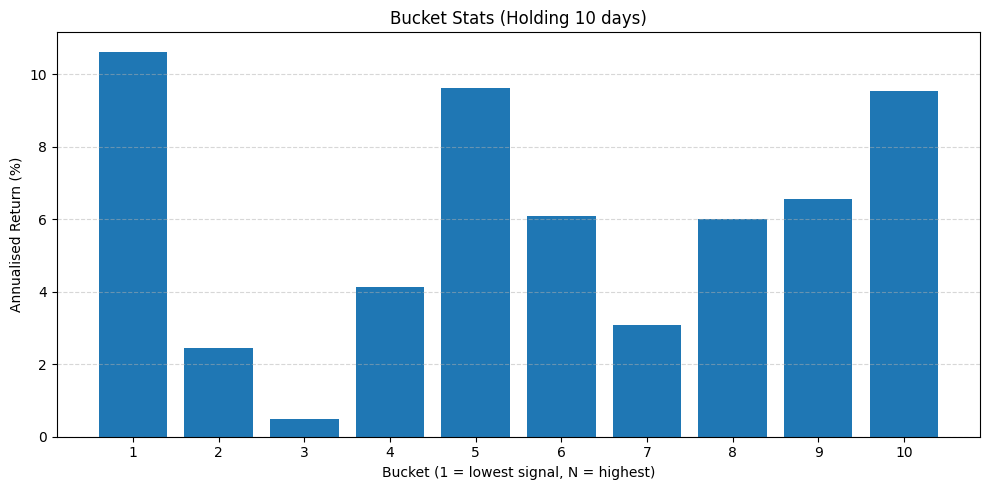

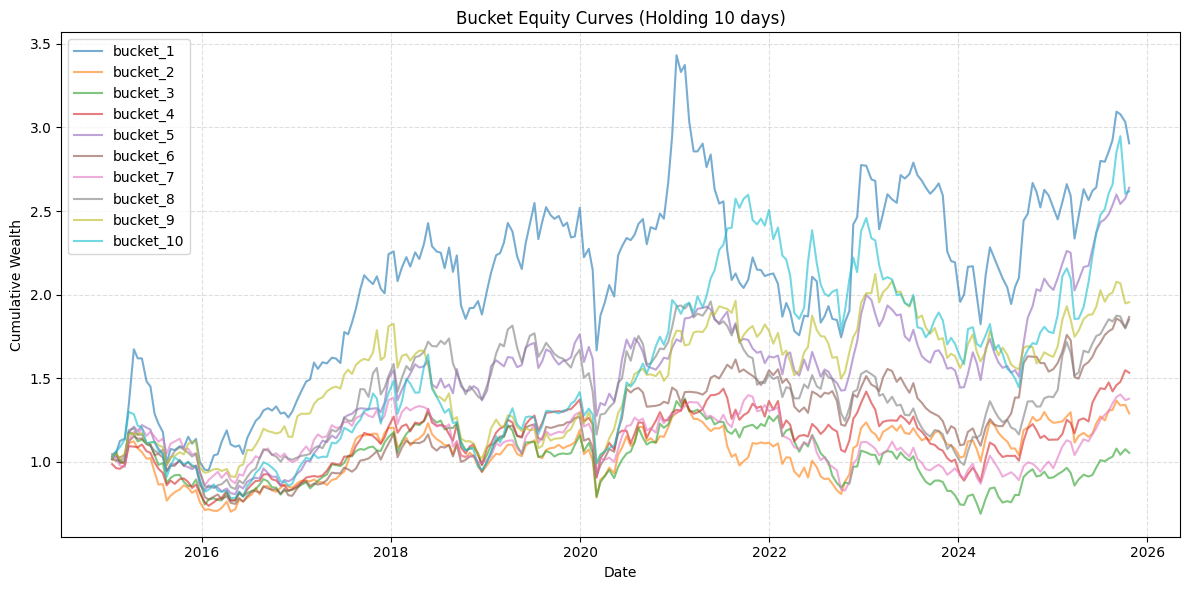


=== Holding 20 days (enter open t+1, exit close t+1+20; non-overlapping) ===
           ann_return   ann_vol    sharpe
bucket_1     0.009224  0.285481  0.032312
bucket_2     0.033145  0.241096  0.137476
bucket_3     0.078860  0.231703  0.340348
bucket_4     0.094004  0.226991  0.414131
bucket_5     0.075103  0.217543  0.345234
bucket_6     0.072411  0.211732  0.341994
bucket_7     0.071587  0.244515  0.292772
bucket_8     0.065833  0.222664  0.295662
bucket_9     0.140852  0.237879  0.592116
bucket_10    0.076662  0.277844  0.275918


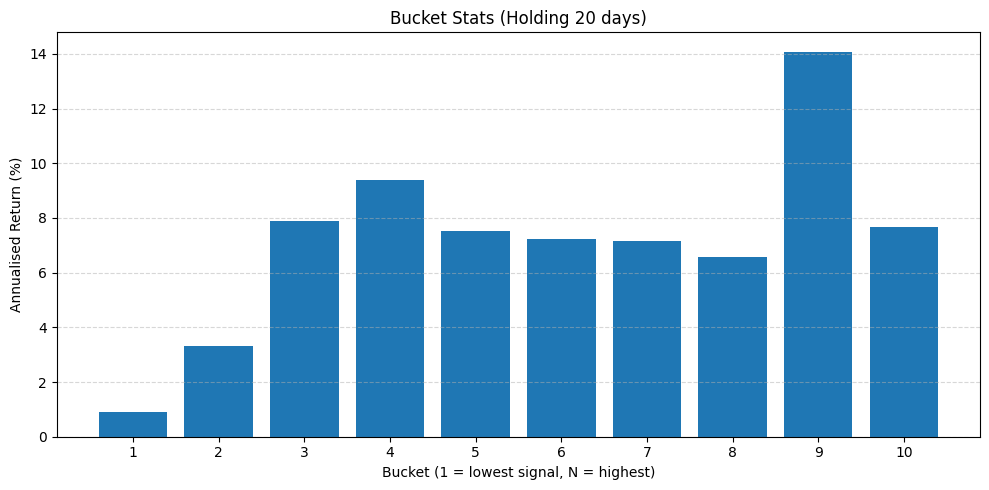

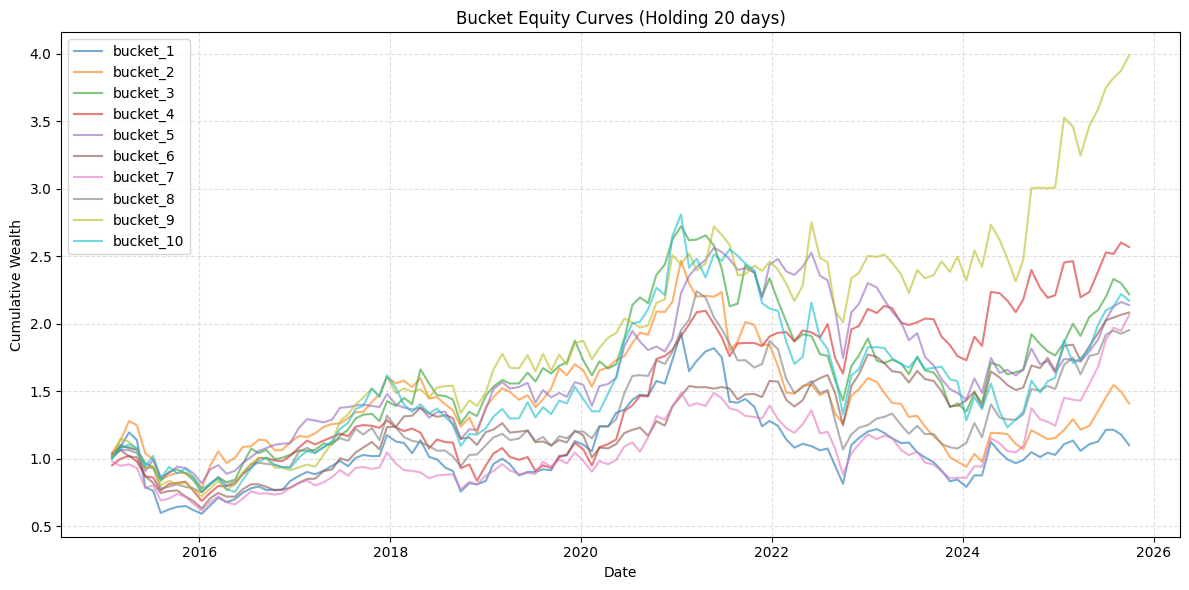

In [66]:
horizons = [1, 5, 10, 20]
results = {}

for H in horizons:
    # forward return aligned at formation date t
    fwd_ret = forward_open_to_close_return(open_u, close_u, horizon=H)
    fwd_ret = fwd_ret.iloc[:-(1 + H)]  # drop tail where exit is missing

    # non-overlapping formation dates (trade window length is H+1 calendar steps)
    step = H + 1
    dates = fwd_ret.index[::step]

    sig_H = signal.reindex(dates)
    fwd_H = fwd_ret.reindex(dates)

    resH = compute_bucket_portfolios(sig_H, fwd_H, n_buckets=10)
    results[H] = resH

    # correct annualisation frequency for H-day holds with step H+1
    freq = TRADING_DAYS_PER_YEAR / (H + 1)

    stats = {}
    for col in resH.bucket_returns.columns:
        r = resH.bucket_returns[col]
        stats[col] = {
            "ann_return": annualised_return(r, freq=freq),
            "ann_vol": annualised_vol(r, freq=freq),
            "sharpe": sharpe_ratio(r, freq=freq),
        }
    stats_df = pd.DataFrame(stats).T

    print(f"\n=== f; non-overlapping) ===")
    print(stats_df[["ann_return", "ann_vol", "sharpe"]])

    plot_bucket_bar_chart(stats_df, title=f"Bucket Stats (Holding {H} days)")
    plot_bucket_equity_curves(resH.bucket_equity, title=f"Bucket Equity Curves (Holding {H} days)")
